In [ ]:
!pip3 install transformers sentencepiece hazm clean-text[gpl]
!pip install pyyaml==5.4.1

In [74]:
!gdown 1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg

Downloading...
From: https://drive.google.com/uc?id=1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg
To: /content/hamshahri.rar
100% 873M/873M [00:06<00:00, 139MB/s]


In [75]:
!unrar x hamshahri.rar
!cp /content/hamshahriold/Corpus/Hamshahri-Categories.txt /content/
!unzip /content/hamshahriold/Corpus/Hamshahri-Corpus.zip
!unzip /content/hamshahriold/Corpus/PersianStopWords.zip


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from hamshahri.rar

Creating    hamshahriold                                              OK
Creating    hamshahriold/CLEF                                         OK
Creating    hamshahriold/CLEF/images                                  OK
Extracting  hamshahriold/CLEF/images/ar.JPG                                0%  OK 
Extracting  hamshahriold/CLEF/images/ar.psd                                0%  OK 
Extracting  hamshahriold/CLEF/images/ar2.JPG                               0%  OK 
Extracting  hamshahriold/CLEF/images/arrow.jpg                             0%  OK 
Extracting  hamshahriold/CLEF/images/basebg1.jpg                           0%  OK 
Extracting  hamshahriold/CLEF/images/basebg2.jpg                           0%  OK 
Extracting  hamshahriold/CLEF/images/celct_name.gif                        0%  OK 
Extracting  hamshahriold/CLEF/images/

In [9]:
import os
import numpy as np
import pandas as pd
import hazm

import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from transformers import AutoConfig, AutoTokenizer, TFAutoModel, AutoModel, DataCollatorWithPadding
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE


# Save data to csv file

In [5]:
# [[DID value, Date value, CAT, text]]
corpus = []
tmp_text = " "
tmp_values = []
c = 0
with open('Hamshahri-Corpus.txt', "rb") as file:
  for line in file:
    line = line.decode("UTF-8")
    if ".DID" in line:
      # some news are abnormal lenght and they are low in number(about 1000)
      if len(tmp_text.split(' ')) < 2500:
        tmp_values.append(tmp_text)
        corpus.append(tmp_values)
      tmp_text = ""
      tmp_values = []
      tmp_values.append(line.replace(".DID\t", "").replace("\r\n",""))
    elif ".Date" in line:
      tmp_values.append(line.replace(".Date\t", "").replace("\r\n","").replace("\\", "/"))
    elif ".Cat" in line:
      tmp_values.append(line.replace(".Cat\t", "").replace("\r\n",""))
    else:
      tmp_text += (line.strip() + " ")
corpus.pop(0)
len(corpus)

164068

In [6]:
df = pd.DataFrame(corpus, columns=['DID', 'date', 'cat', 'text'])
df

,DID,date,cat,text
0,1S1,75/04/02,adabh,جاودانگي در زندگي گروهي از طريق هنر نگاهي به ن...
1,2S1,75/04/02,adabh,رويدادهاي هنري جهان نمايشگاه هنر در خدمت ديكتا...
2,3S1,75/04/02,adabh,برديوار نگارخانه ها گالري گلستان: نمايشگاه طرح...
3,4S1,75/04/02,ejtem,بازي را جدي بگيريم مطالعه اي مقدماتي پيرامون ن...
4,5S1,75/04/02,elmfa,تخته سياه و غباري كه سترده نمي شود... اشاره; ب...
...,...,...,...,...
164063,60055S1,81/11/20,vrzsh,گره هاي كور كشتي باز مي؟ شود گروه ورزشي: با حض...
164064,60055S2,81/11/20,vrzsh,نماينده فدراسيون جهاني واليبال از ايران هر نظر...
164065,60055S3,81/11/20,vrzsh,شكست نامداران تكواندودر پيكارهاي برتر ليگ گروه...
164066,60055S4,81/11/20,vrzsh,ورزشگاه بزرگ دانشگاه آزاد در تهران ساخته مي شو...


In [ ]:
df.to_csv("dataset.csv", date_format='%Y%m%d')

#preprocessing

### stopwords

In [7]:
df = df[['text', 'cat']]

In [8]:
# stop word
stop_words_list = []
with open('PersianStopWords.txt', "rb") as file:
  for line in file:
    stop_words_list.append(line.decode("UTF-8").replace('\r\n', ""))

for idx, txt in enumerate(df["text"]):
  word_tokenized =  hazm.word_tokenize(txt)
  cps = ""
  for word in word_tokenized:
    if word not in stop_words_list:
      cps += word + " "
      
  df.loc[idx].at['text'] = cps
  if idx % 30000 == 0:
    print(idx, "numbers cleaned")

0 numbers cleaned
30000 numbers cleaned
60000 numbers cleaned
90000 numbers cleaned
120000 numbers cleaned
150000 numbers cleaned


### Normalization
The text have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step

In [9]:
# calculate the length of text based on their words
df['text_len_by_words'] = df['text'].apply(lambda t: len(hazm.word_tokenize(t)))
min_max_len = df["text_len_by_words"].min(), df["text_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 0 	Max: 1794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='text_len_by_words'):
    data_length = data[col].values
    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])
    data_glt_rate = (data_glt / len(data_length)) * 100
    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [11]:
minlim, maxlim = 10, 1000
data_gl_than(df, maxlim, minlim)

Texts with word length of greater than 10 and less than 1000 includes 96.26% of the whole!


In [12]:
# remove text with the length of fewer than minlim words and more than maxlim
df['text_len_by_words'] = df['text_len_by_words'].apply(lambda len_t: len_t if minlim <= len_t else None)
df = df.dropna(subset=['text_len_by_words'])
df = df.reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=df['text_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within text',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [14]:
int(np.mean(df['text_len_by_words']))

233

In [15]:
fig = go.Figure()

groupby_cat = df.groupby('cat')['cat'].count()

fig.add_trace(go.Bar(
    x=list(groupby_cat.index),
    y=groupby_cat.tolist(),
    text=groupby_cat.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within text',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

### balance data which their cats are under 1000 instances

In [16]:
group_cats = list(groupby_cat.index)
group_values = list(groupby_cat.values)
remove_cats = []
for idx, cat in enumerate(group_cats):
  if group_values[idx] < 1000:
    remove_cats.append(cat)

In [17]:
df['cat'] = df['cat'].apply(lambda cat: None if cat in remove_cats else cat)
df = df.dropna(subset=['cat'])
df = df.reset_index(drop=True)

In [41]:
labels = list(sorted(df['cat'].unique()))
print(f'We have #{len(labels)}: {labels}')
id2labels = {idx:l for idx, l in enumerate(labels)}
print(id2labels)

We have #21: ['adabh', 'aeqts', 'akhar', 'ejtem', 'elmfa', 'elmif', 'eqtes', 'gozar', 'gungn', 'havad', 'jvarz', 'kharj', 'maqal', 'nnaft', 'polig', 'shahr', 'shari', 'shrst', 'siasi', 'soxan', 'vrzsh']
{0: 'adabh', 1: 'aeqts', 2: 'akhar', 3: 'ejtem', 4: 'elmfa', 5: 'elmif', 6: 'eqtes', 7: 'gozar', 8: 'gungn', 9: 'havad', 10: 'jvarz', 11: 'kharj', 12: 'maqal', 13: 'nnaft', 14: 'polig', 15: 'shahr', 16: 'shari', 17: 'shrst', 18: 'siasi', 19: 'soxan', 20: 'vrzsh'}


#Model loading


### save and load df

In [47]:
df.to_csv("df.csv")

In [15]:
df = pd.read_csv("classification.csv")

##tokenization

In [23]:
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.preprocessing import text


In [17]:
maxlen = 350
corpes = df['text'].tolist()

In [18]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpes)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 431748
Vocabulary Sample: [('كرد', 1), ('است', 2), ('كشور', 3), ('ايران', 4), ('گفت', 5), ('سال', 6), ('تهران', 7), ('شده', 8), ('اسلامي', 9), ('دو', 10)]


In [27]:
encoded_corpes = [[word2id[w] for w in text.text_to_word_sequence(sentences)] for sentences in corpes]

In [8]:
x = sequence.pad_sequences(encoded_corpes, maxlen=maxlen, padding='post', truncating='post')
x.shape

(144992, 350)

### Train,Test split

In [9]:
df['cat_id'] = df['cat'].apply(lambda t: labels.index(t))
y = df['cat_id'].values.tolist()
y = np.array(y)
y.shape

(144992,)

In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
train_dataset = dataset.take(int(0.8 * x.shape[0]))
validation_dataset = dataset.take(int(0.2 * x.shape[0]))

In [20]:
maxlen = 350
embedding_dim = 1024
batch_size = 256
learning_rate = 10

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.4))
model.add(Dense(len(labels), activation='softmax'))


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 1024)         442109952 
                                                                 
 bidirectional (Bidirectiona  (None, 128)              557568    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 21)                2709      
                                                                 
Total params: 442,670,229
Trainable params: 442,670,229
Non-trainable params: 0
_________________________________________________________________


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)

In [16]:
history=model.fit(train_dataset,
                  validation_data=validation_dataset,
                  epochs=10, verbose=2,
                  callbacks=[annealer])
           

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


566/566 - 244s - loss: 2.1141 - accuracy: 0.4063 - val_loss: 1.5645 - val_accuracy: 0.5977 - lr: 1.0000e-04 - 244s/epoch - 431ms/step
Epoch 2/10
566/566 - 225s - loss: 1.4000 - accuracy: 0.6324 - val_loss: 1.0983 - val_accuracy: 0.7263 - lr: 1.0000e-04 - 225s/epoch - 398ms/step
Epoch 3/10
566/566 - 225s - loss: 1.0185 - accuracy: 0.7342 - val_loss: 0.7988 - val_accuracy: 0.7905 - lr: 1.0000e-04 - 225s/epoch - 397ms/step
Epoch 4/10
566/566 - 225s - loss: 0.8008 - accuracy: 0.7867 - val_loss: 0.6408 - val_accuracy: 0.8256 - lr: 1.0000e-04 - 225s/epoch - 398ms/step
Epoch 5/10
566/566 - 225s - loss: 0.6657 - accuracy: 0.8182 - val_loss: 0.5344 - val_accuracy: 0.8492 - lr: 1.0000e-04 - 225s/epoch - 398ms/step
Epoch 6/10
566/566 - 225s - loss: 0.5616 - accuracy: 0.8465 - val_loss: 0.4519 - val_accuracy: 0.8756 - lr: 1.0000e-04 - 225s/epoch - 398ms/step
Epoch 7/10
566/566 - 225s - loss: 0.4874 - accuracy: 0.8688 - val_loss: 0.3897 - val_accuracy: 0.8951 - lr: 1.0000e-04 - 225s/epoch - 397ms/s

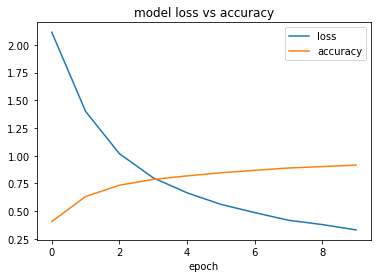

In [17]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

##save/load model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [19]:
model.save_weights("news_classification.h5")

In [33]:
!curl bashupload.com -T ./df.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  322M    0     0  100  322M      0  10.8M  0:00:29  0:00:29 --:--:-- 8267k

Uploaded 1 file, 337 656 974 bytes

wget http://bashupload.com/VD1xN/df.csv


100  322M    0   132  100  322M      4  10.5M  0:00:30  0:00:30 --:--:-- 4632k


In [3]:
!gdown 1--xxbCqpuVSFJc2jHOJzoM2D1pyIiQ92
!gdown 15IeaZh8nNQPW2YJOlvOhHZ2cvtee0Nft

Downloading...
From: https://drive.google.com/uc?id=15IeaZh8nNQPW2YJOlvOhHZ2cvtee0Nft
To: /content/news_classification.h5
100% 1.77G/1.77G [00:15<00:00, 117MB/s]


In [28]:
model.load_weights('/content/news_classification.h5')

#evaluation

In [121]:
def preprocess(texts):
  results = []
  stop_words_list = []
  with open('PersianStopWords.txt', "rb") as file:
    for line in file:
      stop_words_list.append(line.decode("UTF-8").replace('\r\n', ""))
  for txt in texts:
    word_tokenized = hazm.word_tokenize(txt)
    cps = ""
    for word in word_tokenized:
      if word not in stop_words_list:
        cps += word + " "
    results.append(cps)
  return(results)

In [122]:
def prediction(texts):
  result = []
  cleaned_texts = preprocess(texts)
  for cleaned_text in cleaned_texts:
    text_to_sequences = tokenizer.texts_to_sequences([cleaned_text])
    pad_text_to_sequences = sequence.pad_sequences(text_to_sequences, maxlen=maxlen)
    category = model.predict([pad_text_to_sequences])[0]

    category_index = np.where(category == max(category))
    result.append(id2labels[category_index[0][0]])
    print(id2labels[category_index[0][0]])
  return result

In [123]:
text1 = ' پس از جدایی دانیال اسماعیلیفر و تمدید نشدن قرارداد رامین رضائیان در پرسپولیس بسیاری از اهالی فوتبال انتظار این انتقال جنجالی را داشتند. درنهایت این اتفاق رخ داد و روز گذشته چند هفته پس از ماجراهای مربوط به خداحافظی پرحاشیه رامین رضائیان از پرسپولیسیها این بازیکن به عنوان خرید جدید سپاهان و محمدرضا ساکت معرفی شد. با این حال همچنان سپاهان به جذب چند بازیکن دیگر برای حضور قدرتمندانه در لیگ پیش رو نیاز دارد. *سه پست با اولویت سه بازیکن خارجی  سپاهانیها همچنان در پست دفاع میانی بازار را کنکاش میکنند و با توجه به در اختیار داشتن مهدیزاده، دانشگر و نژادمهدی گزینه مد نظر مدیران و کادر فنی سپاهان در این پست یک بازیکن خارجی است.یک خط جلوتر اگرچه سپاهانیها نفراتی نظیر مسعود ریگی، جلال علیمحمدی و محمد کریمی را به عنوان هافبکهای دفاعی مدرن در اختیار دارند و جلوتر از آنها نیز نفراتی نظیر شوشتری، یاسین سلمانی و فرشاد احمدزاده هستند، اما اضافه شدن یک هافبک دیگر از اهداف مد نظر مورایس است و به زودی یک بازیکن خارجی در این پست نیز به اردوی طلاپوشان اصفهانی اضافه خواهد شد.'
text2 = 'میرهاشم موسوی در پاسخ به گلایهها و انتقادات بازنشستگان غیرحداقلیبگیر از نحوه افزایش حقوقها در سال جاری اظهار کرد: آنچه ما باید بر اساس قانون به عنوان سازمان تامین اجتماعی انجام میدادیم همان را انجام دادیم و همان مسیری بوده که تا کنون طی کردهایم.  وی افزود: در ماده ۹۶ قانون تامین اجتماعی قید شده است که میزان افزایش حقوق غیرحداقلیبگیران باید بر اساس هزینههای زندگی تعیین و سپس در هیئت وزیران مصوب شود و به اجرا دربیاید. در ماده ۱۱۱ قانون تامین اجتماعی هم آمده است که میزان افزایش حقوق حداقلیبگیران نباید از حداقل دستمزد کارگران که در شورای عالی کار مصوب شده، کمتر باشد.  مدیرعامل سازمان تامین اجتماعی با بیان اینکه ما بر اساس ماده ۹۶ و ۱۱۱ قانون تامین اجتماعی مسیر افزایش حقوقها را طی کرده و مصوبه هیئت امنای تامین اجتماعی را به دولت ارسال کردیم گفت: این تصمیم، تصمیمِ بخشی و سازمانی ما بود و هیئت امنا همین را پذیرفت و به هیئت دولت ارسال کرد اما اقتضائاتی که در هیئت دولت مطرح است، به علاوه نگاه بخشی ما در تامین اجتماعی است و طبیعتا قانونگذار هم این اختیار را بر اساس ماده ۹۶ به هیئت وزیران داده است که این ملاحظات و اقتضائات را درنظر بگیرد.       موسوی ادامه داد: آن پیشنهادی که ما ارائه دادیم، قانون است و اینکه باید اقتضائات در دولت دیده شود هم قانون است؛ هر دو قانون هستند و نمیتوانیم یک سوی قانون را ببینیم و آن سوی قانون را نادیده بگیریم. خب تصمیم نهایی در هیئت دولت با توجه به ملاحظاتی که برای مابقی صندوقها وجود داشت و همچنین دیگر موارد فرابخشی در اقتصاد کلان و بخشهای مختلف، اتخاذ شد. آنجا هیئت وزیران است و همه باید نظر بدهند و تصمیم نهایی اخذ شود.  وی افزود: البته در جلسات کارشناسی مختلفی که ما حضور داشتیم، نظرات خود را ارائه کرده بودیم و تبیین کارشناسی خودمان را داشتیم. در نهایت  تصمیمی که گرفته شد این بود که برای حداقلی بگیران ۵۷.۴ درصد افزایش داشته باشیم. برای سایر سطوح درآمدی نیز دو سطح قائل شدند، نخست حقوق بگیران زیر ۱۰ میلیون تومان که مشمول افزایش ۱۰ درصدی به علاوه ۶۵۰ هزار تومان مبلغ ثابت شدند و دوم حقوقبگیران بالای ۱۰ میلیون تومان که حقوقشان ۱۰ درصد افزایش پیدا کرد.  مدیرعامل سازمان تامین اجتماعی با اشاره به اینکه برای بخشی از "سایر سطوح" که شاید چیزی حدود به ۹۰۰ هزار نفر بازنشسته را شامل میشود، این تصمیم برای افزایش حقوق، محل سوال شد و معترض بودند اظهار کرد: این موضوع در دولت در حال بررسی بود که هیئت تطبیق قوانین مجلس هم ورود پیدا کرد و نظرات خودشان را اعلام کردند.  موسوی درباره نحوه پرداختهای جبرانی به این گروه از بازنشستگان که پیش از این از سوی سرپرست وزارت رفاه وعده داده و در برخی رسانهها منتشر شده است نیز توضیح داد و گفت: اکنون این موضوع در دولت در حال بررسی است. ما نمیتوانیم بگوییم که با چه الگویی میخواهیم این را جبران کنیم. منتظر تصمیم نهایی هستیم که آنچه باید بر اساس قانون انجام دهیم را انجام دهیم و این آمادگی در تامین اجتماعی وجود دارد که وفق قانون هر تصمیمی گرفته شد را عمل کرده و اقدامی که باید برای این عزیزان در پرداخت مستمریها اتفاق بیفتد را انجام دهد.'
text3 = df["text"][3]

In [124]:
texts = [text1, text2, text3]

In [125]:
prediction(texts)

soxan
gozar
ejtem


['soxan', 'gozar', 'ejtem']